In [1]:
from sklearn.metrics import plot_confusion_matrix
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from common.classification import decision_tree_plot_decision_surfaces
from common.outliers import find_outliers_in_multiple_columns, drop_outliers_from_dataset
from sklearn import tree
from sklearn.neighbors import KernelDensity
from sklearn.model_selection import LeaveOneOut
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib

matplotlib.rcParams['figure.figsize'] = [7, 7]

### Dataset loading and preparation
Please note that the `_preprocessed` file is required. To use this notebook
properly, please execute the preprocessing one first to generate proper dataset
file.

In [2]:
# load dataset from file
data = pd.read_excel("../data/games_sales_2016_preprocessed.xlsx", index_col=0)

# filter used columns
columns_used_for_clustering = ["Critic_Score", "Year_of_Release", "Global_Sales"]
data = data.filter(items=["Name", *columns_used_for_clustering])

# group by game name
data = data.groupby("Name").agg({"Critic_Score": np.mean, "Global_Sales": np.sum, "Year_of_Release": np.mean})\
    .reset_index().sort_values(by="Global_Sales")

data = data.filter(items=columns_used_for_clustering)

### Classification - GlobaL_Sales prediction using Critic_Score

In [3]:
# create artificial clusters
data["cluster"] = 0
data.loc[data["Global_Sales"] > 1, "cluster"] = 1

# print clusters sizes
print("Number of entries in each cluster:\n{}".format(data["cluster"].value_counts()))

Number of entries in each cluster:
0    4952
1    1993
Name: cluster, dtype: int64


### Display clusters and information about them

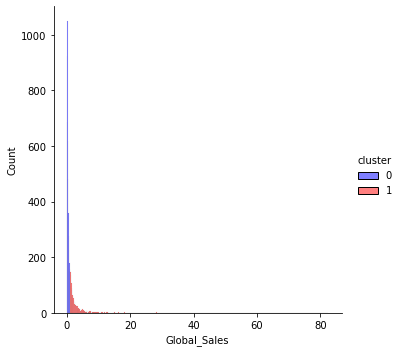

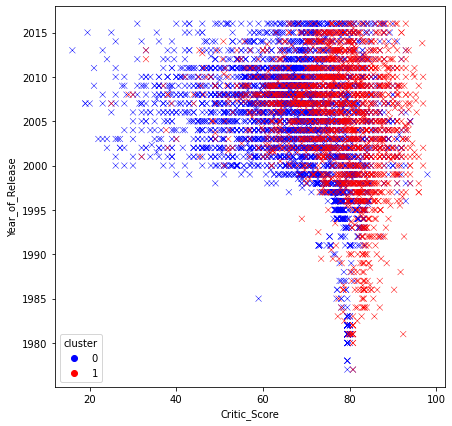

In [4]:
palette = ["blue", "red"]

sns.displot(data, x="Global_Sales", hue="cluster", palette=palette)
plt.show()

sns.scatterplot(data=data, x="Critic_Score", y="Year_of_Release", hue="cluster", palette=palette, marker='x')
plt.show()

### Drop column with Global_Sales - it should not be used in the classification, standardize data

In [203]:
standardization = StandardScaler().fit(data[columns_used_for_clustering])
data[columns_used_for_clustering] = standardization.transform(data[columns_used_for_clustering])
data = data.drop(["Global_Sales"], axis=1)

### Split the dataset into training and testing parts for further studies

In [204]:
training_columns = ["Critic_Score", "Year_of_Release"]

X = data[training_columns].to_numpy()
Y = data["cluster"].to_numpy()

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, stratify=Y)

training_data = pd.DataFrame(np.concatenate((X_train, np.expand_dims(Y_train, axis=1)), axis=1), columns=[*training_columns, "cluster"])
training_data["cluster"] = training_data["cluster"].astype(int)

testing_data = pd.DataFrame(np.concatenate((X_test, np.expand_dims(Y_test, axis=1)), axis=1), columns=[*training_columns, "cluster"])
testing_data["cluster"] = testing_data["cluster"].astype(int)

### Perform classification using KNN, for different numbers of neighbours

K = 1 - test data score: 0.7055435565154787, training data score: 0.8817494600431965
K = 2 - test data score: 0.7350611951043916, training data score: 0.8297336213102952
K = 3 - test data score: 0.7386609071274298, training data score: 0.8353131749460043
K = 4 - test data score: 0.7487401007919366, training data score: 0.8083153347732182
K = 5 - test data score: 0.7264218862491001, training data score: 0.8165946724262059
K = 6 - test data score: 0.7300215982721382, training data score: 0.7976961843052556
K = 7 - test data score: 0.7307415406767459, training data score: 0.7971562275017998
K = 8 - test data score: 0.7293016558675306, training data score: 0.7888768898488121
K = 9 - test data score: 0.7307415406767459, training data score: 0.7888768898488121
K = 10 - test data score: 0.7336213102951764, training data score: 0.7868970482361412
K = 11 - test data score: 0.7278617710583153, training data score: 0.7876169906407487
K = 12 - test data score: 0.734341252699784, training data scor

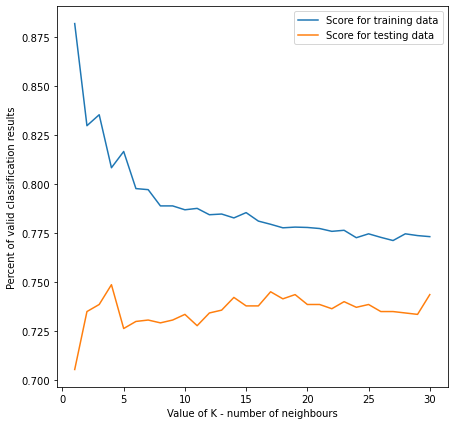

In [205]:
accuracy_test = []
accuracy_train = []
for number_of_neighbours in range(1, 31):
    classifier = KNeighborsClassifier(n_neighbors=number_of_neighbours)\
        .fit(training_data[training_columns], training_data["cluster"])

    test = classifier.score(testing_data[training_columns], testing_data["cluster"])
    train = classifier.score(training_data[training_columns], training_data["cluster"])

    print("K = {} - test data score: {}, training data score: {}".format(number_of_neighbours, test, train))
    accuracy_test.append(test)
    accuracy_train.append(train)

plt.figure()
plt.xlabel("Value of K - number of neighbours")
plt.ylabel("Percent of valid classification results")
plt.plot(range(1, 31), accuracy_train, label="Score for training data")
plt.plot(range(1, 31), accuracy_test, label="Score for testing data")
plt.legend()
plt.show()

### Perform classification using KNN, for K = 15

Accuracy for testing data: 0.7379409647228222
Accuracy for training data: 0.7854571634269258


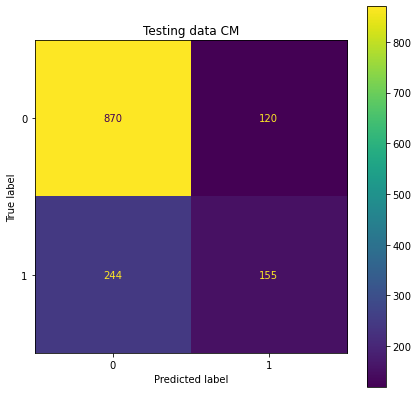

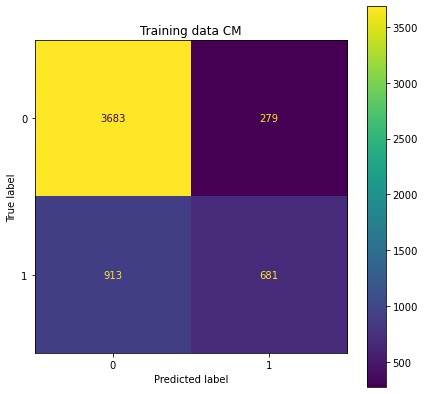

In [206]:
classifier = KNeighborsClassifier(n_neighbors=15)\
    .fit(training_data[training_columns], training_data["cluster"])

accuracy_test = classifier.score(testing_data[training_columns], testing_data["cluster"])
print("Accuracy for testing data: {}".format(accuracy_test))

accuracy_train = classifier.score(training_data[training_columns], training_data["cluster"])
print("Accuracy for training data: {}".format(accuracy_train))

plot_confusion_matrix(classifier, testing_data[training_columns], testing_data["cluster"])
plt.title("Testing data CM")
plt.show()

plot_confusion_matrix(classifier, training_data[training_columns], training_data["cluster"])
plt.title("Training data CM")
plt.show()

### Perform classification using decision tree for different max depths

Max depth = 1 - test data score: 0.7350611951043916, training data score: 0.7582793376529877
Max depth = 2 - test data score: 0.7350611951043916, training data score: 0.7582793376529877
Max depth = 3 - test data score: 0.7350611951043916, training data score: 0.7582793376529877
Max depth = 4 - test data score: 0.7487401007919366, training data score: 0.7615190784737221
Max depth = 5 - test data score: 0.7393808495320374, training data score: 0.7676385889128869
Max depth = 6 - test data score: 0.7365010799136069, training data score: 0.7741180705543557
Max depth = 7 - test data score: 0.7415406767458603, training data score: 0.7807775377969762
Max depth = 8 - test data score: 0.7415406767458603, training data score: 0.7942764578833693
Max depth = 9 - test data score: 0.7257019438444925, training data score: 0.8056155507559395
Max depth = 10 - test data score: 0.7487401007919366, training data score: 0.8198344132469403


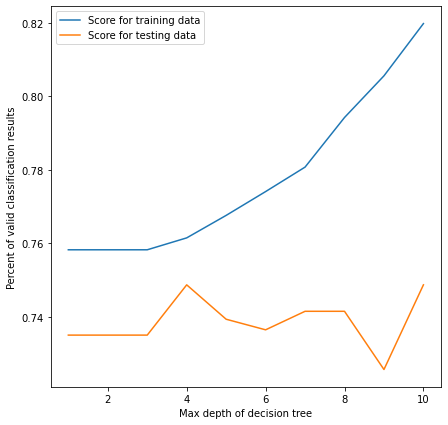

In [207]:
accuracy_test = []
accuracy_train = []
for max_depth in range(1, 11):
    classifier = tree.DecisionTreeClassifier(max_depth=max_depth)\
        .fit(training_data[training_columns], training_data["cluster"])

    test = classifier.score(testing_data[training_columns], testing_data["cluster"])
    train = classifier.score(training_data[training_columns], training_data["cluster"])

    print("Max depth = {} - test data score: {}, training data score: {}".format(max_depth, test, train))
    accuracy_test.append(test)
    accuracy_train.append(train)

plt.figure()
plt.xlabel("Max depth of decision tree")
plt.ylabel("Percent of valid classification results")
plt.plot(range(1, 11), accuracy_train, label="Score for training data")
plt.plot(range(1, 11), accuracy_test, label="Score for testing data")
plt.legend()
plt.show()

### Perform classification using decision tree for max depth = 3

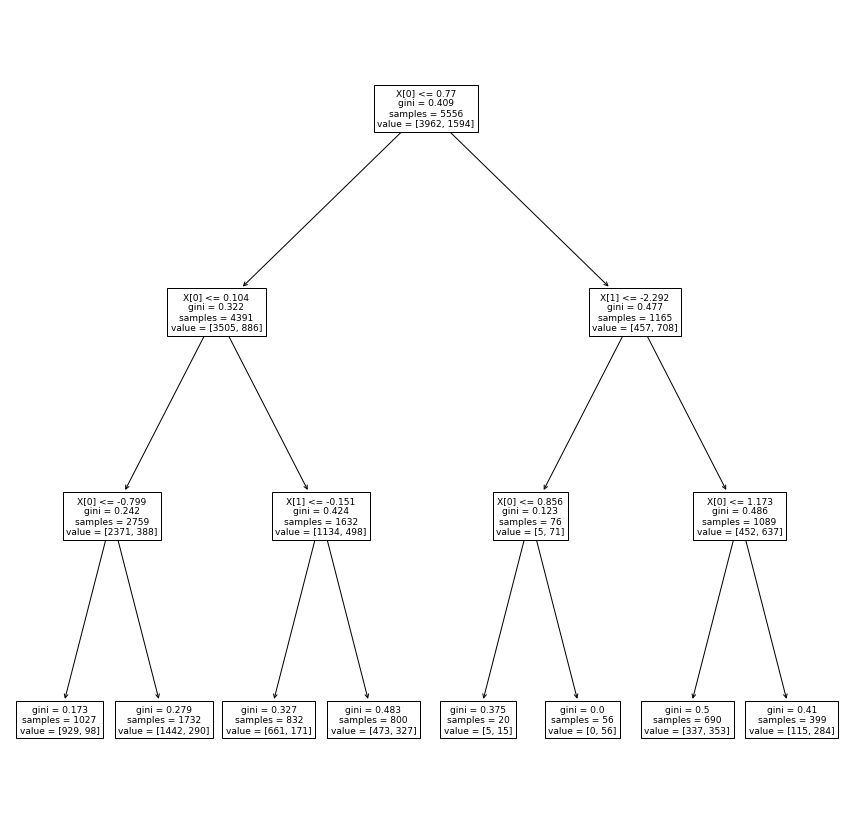

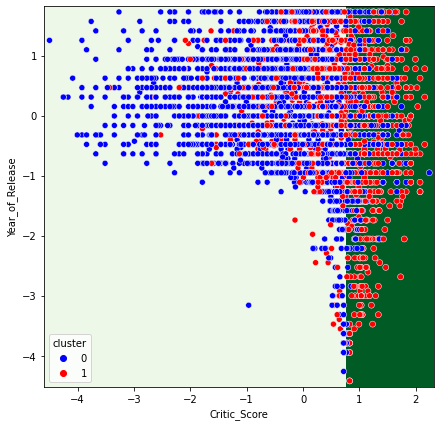

Accuracy for testing data: 0.7350611951043916
Accuracy for training data: 0.7582793376529877


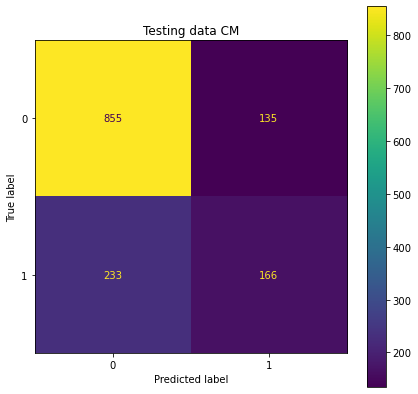

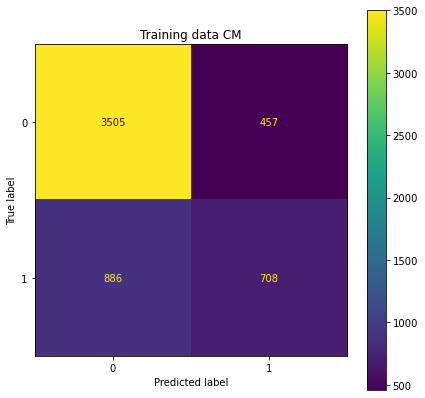

In [208]:
# Note: reducing the depth of this tree has no significant impact on the testing score - only on the training
# score (and even there the impact is not that big) - this is because the tree is "over-fitting"
classifier = tree.DecisionTreeClassifier(max_depth=3)\
    .fit(training_data[training_columns], training_data["cluster"])
plt.figure(figsize=(15, 15))
tree.plot_tree(classifier)
plt.show()
decision_tree_plot_decision_surfaces(classifier, training_data, ("Critic_Score", "Year_of_Release"), palette)
plt.show()

accuracy_test = classifier.score(testing_data[training_columns], testing_data["cluster"])
print("Accuracy for testing data: {}".format(accuracy_test))

accuracy_train = classifier.score(training_data[training_columns], training_data["cluster"])
print("Accuracy for training data: {}".format(accuracy_train))

plot_confusion_matrix(classifier, testing_data[training_columns], testing_data["cluster"])
plt.title("Testing data CM")
plt.show()

plot_confusion_matrix(classifier, training_data[training_columns], training_data["cluster"])
plt.title("Training data CM")
plt.show()


### Perform classification using kernel density estimators

#### Use cross-validation to get proper bandwidths

In [209]:
bandwidths_for_classes = []
for cl in range(0, 2):

    tr_data = training_data[training_data["cluster"] == cl]
    bandwidths = 10 ** np.linspace(-1, 1, 100)
    grid = GridSearchCV(KernelDensity(kernel='gaussian'),
                    {'bandwidth': bandwidths},
                    cv=LeaveOneOut())
    grid.fit(tr_data[training_columns])
    bandwidths_for_classes.append(grid.best_params_["bandwidth"])
    print("Bandwidth for class {}: {}".format(cl, grid.best_params_["bandwidth"]))

Bandwidth for class 0: 0.12618568830660204
Bandwidth for class 1: 0.1592282793341092


#### Plot resulting KDEs

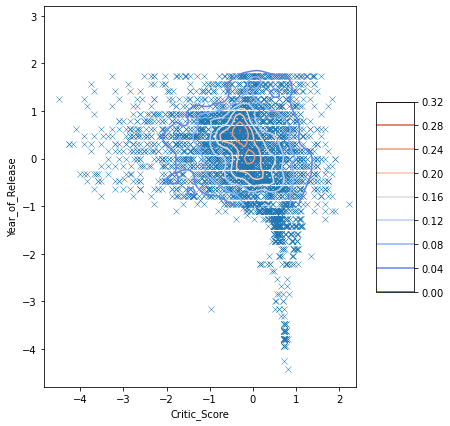

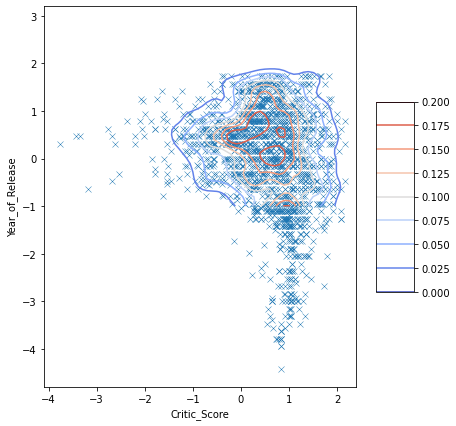

In [210]:
for cl in range(0, 2):

    tr_data = training_data[training_data["cluster"] == cl]
    kde = KernelDensity(bandwidth=bandwidths_for_classes[cl], kernel="gaussian")\
        .fit(tr_data[training_columns])

    X = np.arange(-4.1, 2.5, 0.1).tolist()
    Y = np.arange(-1, 3.3, 0.1).tolist()
    X, Y = np.meshgrid(X, Y)

    inp = np.vstack((X.ravel(), Y.ravel())).T

    result = np.exp(kde.score_samples(inp))
    result = np.reshape(result, X.shape)

    fig = plt.figure()
    sns.scatterplot(data=tr_data, x="Critic_Score", y="Year_of_Release", marker='x')
    p = plt.contour(X, Y, result, cmap='coolwarm')
    fig.colorbar(p, shrink=0.5, aspect=5)
    plt.show()

#### Prepare KDEs objects

In [211]:
tr_data_cl0 = training_data[training_data["cluster"] == 0]
kde_cl0 = KernelDensity(bandwidth=bandwidths_for_classes[0], kernel="gaussian")\
    .fit(tr_data_cl0[training_columns])

tr_data_cl1 = training_data[training_data["cluster"] == 1]
kde_cl1 = KernelDensity(bandwidth=bandwidths_for_classes[1], kernel="gaussian")\
    .fit(tr_data_cl1[training_columns])

#### Perform classification - training dataset

In [212]:
correct_classifications = 0
kde_cl0_scores = np.exp(kde_cl0.score_samples(training_data[training_columns]))
kde_cl1_scores = np.exp(kde_cl1.score_samples(training_data[training_columns]))

for index, row in training_data.iterrows():
    scores = [kde_cl0_scores[index], kde_cl1_scores[index]]
    max_index = scores.index(max(scores))
    if max_index == row["cluster"]:
        correct_classifications += 1

print(correct_classifications / len(training_data.index))



0.7251619870410367


#### Perform classification - testing dataset

In [213]:
correct_classifications = 0
kde_cl0_scores = np.exp(kde_cl0.score_samples(testing_data[training_columns]))
kde_cl1_scores = np.exp(kde_cl1.score_samples(testing_data[training_columns]))

for index, row in testing_data.iterrows():
    scores = [kde_cl0_scores[index], kde_cl1_scores[index]]
    max_index = scores.index(max(scores))
    if max_index == row["cluster"]:
        correct_classifications += 1

print(correct_classifications / len(testing_data.index))




0.6911447084233261
